# Building a CNN from Scratch
This notebook contains all of the code we wrote to build and tune a CNN from scratch. It also contains much discussion about the process of doing so. This notebook is built on the work we did primarily for the first part of Milestone 4.

- Complete description of the deep network you trained from scratch, including parameter settings, performance, features learned, etc. 
- Discussion of the results, how much improvement you gained with fine tuning, etc. 

In [14]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten

## Getting the Data

All data preprocessing code is in `PreMilestone4DataCleaning.ipynb`.

In [16]:
data_19 = pd.read_csv("final_dataset_19_labels.csv")
data_3 = pd.read_csv("final_dataset_3_labels.csv")

print "Data_19 shape:", data_19.shape
print "Data_3 shape:", data_3.shape

Data_19 shape: (7220, 31)
Data_3 shape: (7220, 15)


In [17]:
data_19.head(1)

,10402,10749,10751,10752,10770,12,14,16,18,27,...,lead actors,movie_id,overview,popularity,poster_path,release_date,title,video,vote_average,vote_count
0,0,0,0,0,0,0,0,0,1,0,...,"[u'Amy Adams', u'Jeremy Renner', u'Forest Whit...",329865,Taking place after alien crafts land around th...,25.66195,/hLudzvGfpi6JlwUnsNhXwKKg4j.jpg,2016-11-10,Arrival,False,6.9,3510


In [18]:
data_3.head(1)

,adult,director,lead actors,movie_id,overview,popularity,poster_path,release_date,title,video,vote_average,vote_count,other,heartbeat,lighthearted
0,False,Denis Villeneuve,"[u'Amy Adams', u'Jeremy Renner', u'Forest Whit...",329865,Taking place after alien crafts land around th...,25.66195,/hLudzvGfpi6JlwUnsNhXwKKg4j.jpg,2016-11-10,Arrival,False,6.9,3510,0,1,0


Note how the 3 label columns are at the end of the data_3 dataframe ("other", "heartbeat", "lighthearted"). This dataframe does not contain any of the 19 original labels. For more information on why we chose to collapse genres, see our analysis later in this notebook. In short, 19 labels makes it hard for our NN to exceed trivial accuracy.

## Building Training and Testing Sets

Now we need training and testing data. We have a bunch of images named 
by their movie ids in the "all_train_imgs/" folder.

To get the data, we can take all the movies for which we have images and then
split these movies intro train and test sets. Then, we'll just index
into the dataframes based on these ids to build train and test sets!

In [22]:
# gets all movie ids for which we have images
m_ids = map(int, map(lambda x: x[:-4], os.listdir("final_imgs_folder/all_train_imgs/")))

# shuffle the ids to get a random sample
np.random.shuffle(m_ids)

# keep 70% of the movies for training
train_size = int(math.floor(.7 * len(m_ids)))

# divide into train and test sets
train_ids = m_ids[:train_size]
test_ids = m_ids[train_size:]

In [24]:
# these are the label names of the original (full) multilabel matrix
orig_label_names = data_19.columns[:19]

# these are the new label names that we created so that our NN could
# exceed baseline accuracy
new_label_names = ["other", "lighthearted", "heartbeat"]

# y_train and y_test for the full dataframe with all 19 genres
y_train_19 = np.array([data_19[data_19.movie_id == movie_id][orig_label_names].values[0] for movie_id in train_ids])
y_test_19  = np.array([data_19[data_19.movie_id == movie_id][orig_label_names].values[0] for movie_id in test_ids])

# y_train and y_test for the collapsed dataframe with just 3 genre categories
y_train_3 = np.array([data_3[data_3.movie_id == movie_id][new_label_names].values[0] for movie_id in train_ids])
y_test_3  = np.array([data_3[data_3.movie_id == movie_id][new_label_names].values[0] for movie_id in test_ids])

# should be (num_samples, num_labels)
print "y_train_19 shape:", y_train_19.shape
print "y_test_19 shape:", y_test_19.shape

# should be (num_samples, num_labels)
print "y_train_3 shape:", y_train_3.shape
print "y_test_3 shape:", y_test_3.shape

y_train_19 shape: (1813, 19)
y_test_19 shape: (778, 19)
y_train_3 shape: (1813, 3)
y_test_3 shape: (778, 3)


In [27]:
def reshape(x_train, x_test, img_rows, img_cols, grayscale=True):
    """
    Code inspired from the Keras_CNN lab
    
    Now we need to reshape x_train and x_test so that they work with CNNs.
    Following the example in "labs/Keras_CNN.ipynb", this needs to be an array 
    of images with shape determined by the backend, including the depth dimension,
    which is 1 for grayscale and 3 for RGB
    """
    # we're either using grayscale (1 channel) or rgb (3 channels)
    if grayscale:
        depth = 1
    else:
        depth = 3
    
    if K.image_data_format() == 'channels_first':
        x_train = x_train.reshape(x_train.shape[0], depth, img_rows, img_cols)
        x_test = x_test.reshape(x_test.shape[0], depth, img_rows, img_cols)
        input_shape = (depth, img_rows, img_cols)
    else:
        x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, depth)
        x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, depth)
        input_shape = (img_rows, img_cols, depth)

    # normalize image values to [0,1]
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255

    print "x_train shape:", x_train.shape
    print x_train.shape[0], "train samples"
    print x_test.shape[0], "test samples"
    
    return x_train, x_test, input_shape

To make the transition between using different images easier, let's write a wrapper function which both loads the images into memory and also reshapes them so that they're ready to go!

In [30]:
def get_X_data(INPUT_DIR, N_ROWS, N_COLS, grayscale=True):
    """
    Given the directory of images which are already manipulated (Resized, etc.),
    load them into train and test sets. Pass N_ROWS and N_COLS so we know how to reshape,
    and also say if grayscale so we know how to set the depth.
    """
    # these are independent of which label set we use
    x_train = np.array([np.asarray(Image.open(INPUT_DIR + str(m_id) + ".jpg")) for m_id in train_ids])
    x_test =np.array([np.asarray(Image.open(INPUT_DIR + str(m_id) + ".jpg")) for m_id in test_ids])
    
    return reshape(x_train, x_test, N_ROWS, N_COLS, grayscale=grayscale)

In [31]:
x_train_gray_32_32, x_test_gray_32_32, input_shape_gray_32_32 = \
    get_X_data("final_imgs_folder/gray_32_32/", 32, 32)

x_train shape: (1813, 32, 32, 1)
1813 train samples
778 test samples


In [93]:
x_train_gray_64_64, x_test_gray_64_64, input_shape_gray_64_64 = \
    get_X_data("final_imgs_folder/gray_64_64/", 64, 64)

x_train shape: (1813, 64, 64, 1)
1813 train samples
778 test samples


In [96]:
x_train_rgb_32_32, x_test_rgb_32_32, input_shape_color_32_32 = \
    get_X_data("final_imgs_folder/rgb_32_32/", 32, 32, grayscale=False)

x_train shape: (1813, 32, 32, 3)
1813 train samples
778 test samples


In [100]:
x_train_rgb_64_64, x_test_rgb_64_64, input_shape_color_64_64 = \
    get_X_data("final_imgs_folder/rgb_64_64/", 64, 64, grayscale=False)

x_train shape: (1813, 64, 64, 3)
1813 train samples
778 test samples


## Functions for Building CNNs

Now let's write some functions to do the CNN building. This will involve creating the Keras model given a set of parameters, compiling the model, training it, and doing some plotting.

In [38]:
def build_cnn(n_layers, filters, kernels, a_func, input_shape=None, n_labels=None):
    """
    Wrapper function to create a CNN from scratch.
    
    We treat the number of layers, filter size, kernel size, and activation 
    function as parameters which can then be tuned.
    """
    # create an empty network model
    model = Sequential()
    
    for i in range(n_layers):
        # define the input layer to the CNN
        # input shape is a tuple of the # rows, # cols, and # channels (1 for grayscale)
        # the first parameter to Conv2D is the number of filters we want to convolve
        # over the input images
        model.add(Conv2D(filters[i], 
                         kernel_size=kernels[i], 
                         activation=a_func, 
                         input_shape=input_shape)
                 )

        # create a max pooling layer
        model.add(MaxPooling2D(pool_size=(2, 2)))

    # flatten for fully connected classification layer
    model.add(Flatten())

    # --- fully connected layer ---
    model.add(Dense(64, activation='relu'))

    # recommended by: https://github.com/fchollet/keras/issues/761
    # uses a sigmoid activation rather than softmax, which apparently
    # gives us a label vector back
    model.add(Dense(n_labels, activation='sigmoid'))

    return model

In [34]:
def compile_cnn(model, loss="binary_crossentropy", lr=0.1, momentum=0.9):
    """
    Compiles a CNNs
    """
    # the setup is our basic categorical crossentropy with stochastic gradient decent
    # we also specify that we want to evaluate our model in terms of accuracy
    sgd = SGD(lr=0.1, momentum=0.9)

    # compile the model
    model.compile(loss=loss,
                  optimizer=sgd,
                  metrics=["accuracy"])

In [35]:
def train_cnn(model=None, x_train=None, y_train=None, x_test=None, y_test=None, batch_size=None, epochs=50):
    """
    Fit the CNN and score it against the test data
    
    Returns (history, score)
    """
    # this is now the actual training
    # in addition to the training data we provide validation data
    # this data is used to calculate the performance of the model over all the epochs
    # this is useful to determine when training should stop
    # in our case we just use it to monitor the evolution of the model over the training epochs
    # if we use the validation data to determine when to stop the training or which model to save, we 
    # should not use the test data, but a separate validation set. 
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0,
                        # this will use 30% of the train data as hold out
                        # for validation
                        validation_split=.3)

    # once training is complete, let's see how well we have done
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    return history, score

In [90]:
def plot_acc(model_history, baseline=None, add_title=""):
    """
    Given the history returned by training the model, plot
    the train and test accuracies together
    """
    plt.figure(figsize=(8, 6))

    max_train_acc = round(max(model_history.history['acc']), 2)
    max_test_acc = round(max(model_history.history['val_acc']), 2)

    plt.plot(model_history.history['acc'], 
             label="Train Acc (Max = {0})".format(max_train_acc))
    plt.plot(model_history.history['val_acc'], 
             label="Test Acc (Max = {0})".format(max_test_acc))
    plt.axhline(baseline, ls='--', c="r", label="Baseline: {0}".format(round(baseline, 3)))

    plt.title("Model accuracy as a function of epochs: " + add_title)
    plt.xlabel("epoch")
    plt.legend(loc="lower right")
    plt.ylabel("accuracy")
    plt.show()

## Establishing Baseline Accuracy

Let's first find our basline accuracy for our two different label sets (i.e. the entire genre set with 19 labels and the more general categorization with just 3 labels). 

We'll use this baseline as a comparison point for the accuracy of our neural networks. The goal is to exceed the baseline, which is the accuracy that a trivial classifier would achieve (e.g. if it just guessed the most frequest label).

In [43]:
# calculate the base rate for the dataset with 19 labels
accuracy_list = [] 
for y in y_train_19: 
    for x in y:
        accuracy_list.append(x == 0)
    
BASELINE_ACC_19 = np.mean(accuracy_list)
print "This is our baseline accuracy for the dataset w/19 labels:", round(BASELINE_ACC_19, 3)

# calculate the base rate for the dataset with 3 labels
accuracy_list = [] 
for y in y_train_3: 
    for x in y:
        accuracy_list.append(x == 0)
    
BASELINE_ACC_3 = np.mean(accuracy_list)
print "This is our baseline accuracy for the dataset w/19 labels:", round(BASELINE_ACC_3, 3)

This is our baseline accuracy for the dataset w/19 labels: 0.843
This is our baseline accuracy for the dataset w/19 labels: 0.525


This might be an incorrect way to calculate baseline accuracy, at least for the dataset with just 3 labels. A trivial classifier for a multilabel problem **might** guess the most frequent value for each label, as opposed to the most frequent value overall. Thus, the real baseline accuracy could also be an average of the baseline accuracies for each individual (e.g. the average of the baseline accuracy for "other", "lighthearted", and "heartbeat). 

Thus, our real baseline accuracy might be slightly more conservative. Let's calculate that now:

In [58]:
a, b = np.unique(y_train_3[:,0], return_counts=True)
a, b

(array([0, 1]), array([1526,  287]))

In [59]:
c, d = np.unique(y_train_3[:,1], return_counts=True)
c, d

(array([0, 1]), array([1208,  605]))

In [60]:
e, f = np.unique(y_train_3[:,2], return_counts=True)
e, f

(array([0, 1]), array([ 120, 1693]))

Averaging the three baselines, we get roughly:

In [62]:
CONS_BASELNE_ACC_3 = (1.0 * b[0]/ sum(b) + 1.0 * d[0] / sum(d) + 1.0 * f[1] / sum(f)) / 3
CONS_BASELNE_ACC_3

0.8139363853649568

This means that we could effectively guess 0 for the first and second, and 1 for the third column and get roughly 81% accuracy.

### Baseline Summary:

In summary, we have 3 baselines: 1 for the dataset with 19 labels, 1 for the dataset with 3 labels that looks at overall label frequency, and 1 for the dataset with 3 labels that looks at average label frequency for each column.

We choose not to look at the average label frequency for each column for the dataset with 19 labels because, if anything, it's more conservative than the overall frequency that we've already calculated. As we show below, we can't even beat this more liberal baseline!

In [64]:
print "Baseline for 19 labels:", round(BASELINE_ACC_19, 3)
print "Liberal Baseline for 3 labels:", round(BASELINE_ACC_3, 3)
print "Conservative Baseline for 3 labels:", round(CONS_BASELNE_ACC_3, 3)

Baseline for 19 labels: 0.843
Liberal Baseline for 3 labels: 0.525
Conservative Baseline for 3 labels: 0.814


## Building Various CNNs 

In [66]:
# lets set a standard for epochs and batch size now, though
# we can just change this as we go in case a model shows interesting
# prediction behavior past 50 epochs

# this seems like a reasonable first choice because it gives us
# enough epochs to see long term behavior without taking forever to run.
# that said, this should be increased as necessary if we see interesting
# long-run behavior
epochs = 50

# This is a reasonable batch size because it's likely
# big enough to approximate the distribution of our data
# at least reasonably, though we should increase this if
# our models aren't taking too long to run so that 
# we can see how performance changes with a more accurate
# distribution of data
batch_size = 128

In [67]:
# holds the history object and score object from each model we try
# out in case we want to make comparison plots later!
model_info = {}

Now, we have many different combinations of size, color, and labels that we could try out for each model. There are 8 combinations in total:

* 32x32 G 3
* 32x32 G 19
* 32x32 RGB 3
* 32x32 RGB 19
* 64x64 G 3
* 64x64 G 19
* 64x64 RGB 3
* 64x64 RGB 19

From much of the work we did in Milestone #4, we know that we haven't really been able to exceed baseline accuracy for 19 labels. So it's more important to focus on different combinations of size and color in predicting just 3 labels.

### Model 1 (32x32 GrayScale, 19 Labels)
* 1 convolution layer & 1 pool layer
* 8 filters applied to convolution layer
* Convolution kernels of size 3x3
* relU activation function

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 30, 30, 8)         80        
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 15, 15, 8)         0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 1800)              0         
_________________________________________________________________
dense_33 (Dense)             (None, 64)                115264    
_________________________________________________________________
dense_34 (Dense)             (None, 19)                1235      
Total params: 116,579.0
Trainable params: 116,579.0
Non-trainable params: 0.0
_________________________________________________________________
('Test loss:', 0.43171124102830272)
('Test accuracy:', 0.82099841293761544)


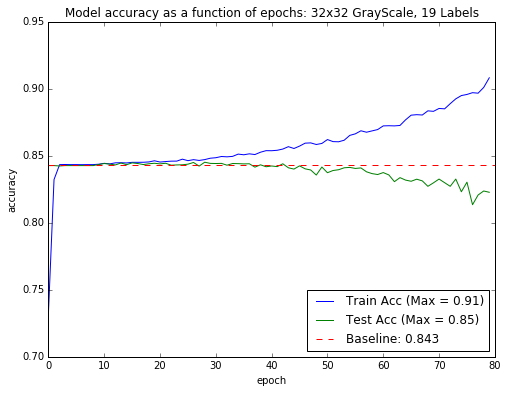

In [91]:
model = build_cnn(n_layers=1, 
                    filters=[8], 
                    kernels=[(3,3)],
                    input_shape = input_shape_gray_32_32,
                    n_labels = 19,
                    a_func='relu')

model.summary()
compile_cnn(model)

model_history, model_score = train_cnn(model=model, 
                                           x_train=x_train_gray_32_32, 
                                           y_train=y_train_19,
                                           x_test=x_test_gray_32_32,
                                           y_test=y_test_19, 
                                           batch_size=batch_size, 
                                           epochs=80)


model_info["model_1"] = {}
model_info["model_1"]["model_history"] = model_history
model_info["model_1"]["model_score"] = model_score

plot_acc(model_history, baseline=BASELINE_ACC_19, add_title="32x32 GrayScale, 19 Labels")

We clearly start to overfit about halfway though, at which point test accuracy dips because we're starting to model noise and training accuracy increases. At its best, out model is about 85% accurate on our test data, which is just slightly better than the baseline.

### Model 1 Again (32x32 GrayScale, 3 Labels)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 30, 30, 8)         80        
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 15, 15, 8)         0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 1800)              0         
_________________________________________________________________
dense_35 (Dense)             (None, 64)                115264    
_________________________________________________________________
dense_36 (Dense)             (None, 3)                 195       
Total params: 115,539.0
Trainable params: 115,539.0
Non-trainable params: 0.0
_________________________________________________________________
('Test loss:', 1.526509975406382)
('Test accuracy:', 0.76649531178118946)


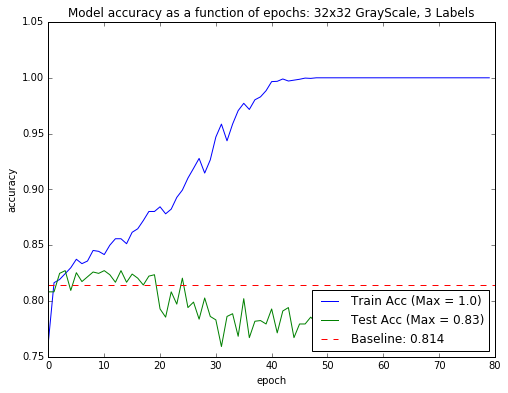

In [92]:
model = build_cnn(n_layers=1, 
                    filters=[8], 
                    kernels=[(3,3)],
                    input_shape = input_shape_gray_32_32,
                    n_labels = 3,
                    a_func='relu')

model.summary()
compile_cnn(model)

model_history, model_score = train_cnn(model=model, 
                                           x_train=x_train_gray_32_32, 
                                           y_train=y_train_3,
                                           x_test=x_test_gray_32_32,
                                           y_test=y_test_3, 
                                           batch_size=batch_size, 
                                           epochs=80)


model_info["model_1"] = {}
model_info["model_1"]["model_history"] = model_history
model_info["model_1"]["model_score"] = model_score

plot_acc(model_history, baseline=CONS_BASELNE_ACC_3, add_title="32x32 GrayScale, 3 Labels")

Nice! Looks like we're doing a little bit better than the baseline for the first 20 epochs, though dipping very far down after that due to overfitting.

Let's also try this model on bigger images, as well as color images!

### Model 1 Again (64x64 GrayScale, 3 Labels)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 62, 62, 8)         80        
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 31, 31, 8)         0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 7688)              0         
_________________________________________________________________
dense_37 (Dense)             (None, 64)                492096    
_________________________________________________________________
dense_38 (Dense)             (None, 3)                 195       
Total params: 492,371.0
Trainable params: 492,371.0
Non-trainable params: 0.0
_________________________________________________________________
('Test loss:', 1.5424569486652364)
('Test accuracy:', 0.78834620646768483)


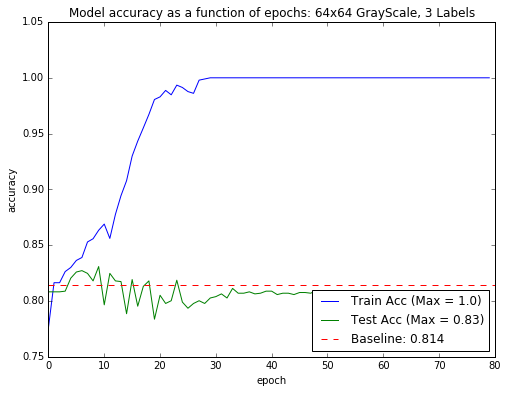

In [94]:
model = build_cnn(n_layers=1, 
                    filters=[8], 
                    kernels=[(3,3)],
                    input_shape = input_shape_gray_64_64,
                    n_labels = 3,
                    a_func='relu')

model.summary()
compile_cnn(model)

model_history, model_score = train_cnn(model=model, 
                                           x_train=x_train_gray_64_64, 
                                           y_train=y_train_3,
                                           x_test=x_test_gray_64_64,
                                           y_test=y_test_3, 
                                           batch_size=batch_size, 
                                           epochs=80)


model_info["model_1"] = {}
model_info["model_1"]["model_history"] = model_history
model_info["model_1"]["model_score"] = model_score

plot_acc(model_history, baseline=CONS_BASELNE_ACC_3, add_title="64x64 GrayScale, 3 Labels")

Using bigger images doesn't actually seem to help, wierdly enough. That said, it does look like the training accuracy approahes 1 way fast (at epoch 25) vs. when we were using 32x32 images (epoch 40). Unforutnately, test acc does not increase.

Let's try color images...

### Model 1 Again (32x32 RGB, 3 Labels)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 30, 30, 8)         224       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 15, 15, 8)         0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 1800)              0         
_________________________________________________________________
dense_41 (Dense)             (None, 64)                115264    
_________________________________________________________________
dense_42 (Dense)             (None, 3)                 195       
Total params: 115,683.0
Trainable params: 115,683.0
Non-trainable params: 0.0
_________________________________________________________________
('Test loss:', 1.4114793768885203)
('Test accuracy:', 0.79520139688084857)


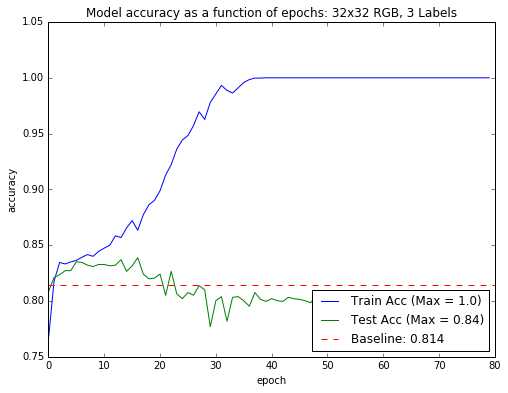

In [99]:
model = build_cnn(n_layers=1, 
                    filters=[8], 
                    kernels=[(3,3)],
                    input_shape = input_shape_color_32_32,
                    n_labels = 3,
                    a_func='relu')

model.summary()
compile_cnn(model)

model_history, model_score = train_cnn(model=model, 
                                           x_train=x_train_rgb_32_32, 
                                           y_train=y_train_3,
                                           x_test=x_test_rgb_32_32,
                                           y_test=y_test_3, 
                                           batch_size=batch_size, 
                                           epochs=80)


model_info["model_1"] = {}
model_info["model_1"]["model_history"] = model_history
model_info["model_1"]["model_score"] = model_score

plot_acc(model_history, baseline=CONS_BASELNE_ACC_3, add_title="32x32 RGB, 3 Labels")

### Model 1 Again (64x64 RGB, 3 Labels)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 62, 62, 8)         224       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 31, 31, 8)         0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 7688)              0         
_________________________________________________________________
dense_45 (Dense)             (None, 64)                492096    
_________________________________________________________________
dense_46 (Dense)             (None, 3)                 195       
Total params: 492,515.0
Trainable params: 492,515.0
Non-trainable params: 0.0
_________________________________________________________________
('Test loss:', 1.6544263387400571)
('Test accuracy:', 0.79177380113797813)


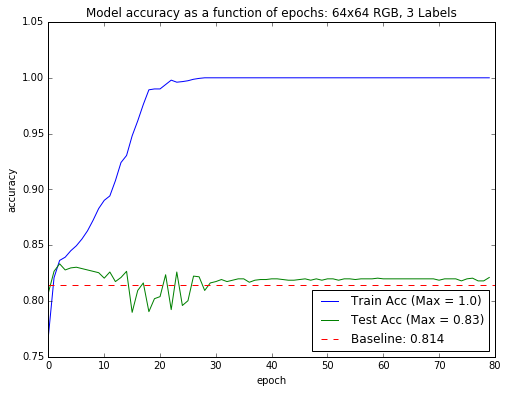

In [102]:
model = build_cnn(n_layers=1, 
                    filters=[8], 
                    kernels=[(3,3)],
                    input_shape = input_shape_color_64_64,
                    n_labels = 3,
                    a_func='relu')

model.summary()
compile_cnn(model)

model_history, model_score = train_cnn(model=model, 
                                           x_train=x_train_rgb_64_64, 
                                           y_train=y_train_3,
                                           x_test=x_test_rgb_64_64,
                                           y_test=y_test_3, 
                                           batch_size=batch_size, 
                                           epochs=80)


model_info["model_1"] = {}
model_info["model_1"]["model_history"] = model_history
model_info["model_1"]["model_score"] = model_score

plot_acc(model_history, baseline=CONS_BASELNE_ACC_3, add_title="64x64 RGB, 3 Labels")

Big, color images, only give us 83% accuracy on the test set, which is the same 32x32 grayscale (which has way fewer parameters).

As we know from Milestone 4, it seems as if Models 1 and 3 were best, so let's continue trying different paratmeres of shape, size, and color, just for Model 3 now.

### Model 3 (32x32 GrayScale, 19 labels)
* 4 convolution layers & 4 pool layers
* 32 filters applied to convolution layer
* Convolution kernels of size 2, 2
* relU activation function

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 31, 31, 32)        160       
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 14, 14, 32)        4128      
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 6, 6, 32)          4128      
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 2, 2, 32)          4128      
__________

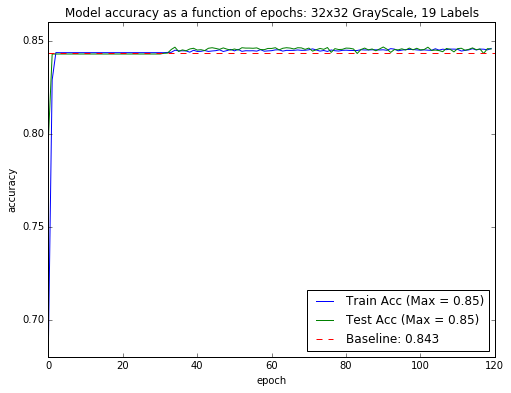

In [105]:
model = build_cnn(n_layers=4, 
                    filters=[32] * 4, 
                    kernels=[(2,2)] * 4, 
                    input_shape = input_shape_gray_32_32,
                    n_labels = 19,
                    a_func='relu')

model.summary()
compile_cnn(model)

model_history, model_score = train_cnn(model=model, 
                                           x_train=x_train_gray_32_32, 
                                           y_train=y_train_19,
                                           x_test=x_test_gray_32_32,
                                           y_test=y_test_19, 
                                           batch_size=batch_size,
                                           epochs=120)

model_info["model_3"] = {}
model_info["model_3"]["model_history"] = model_history
model_info["model_3"]["model_score"] = model_score

plot_acc(model_history, baseline=BASELINE_ACC_19, add_title="32x32 GrayScale, 19 Labels")

We're again doing slightly just better than the baseline with 19 labels, but barely.

### Model 3 Again (32x32 GrayScale, 3 Labels)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 31, 31, 32)        160       
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 14, 14, 32)        4128      
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 6, 6, 32)          4128      
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 2, 2, 32)          4128      
__________

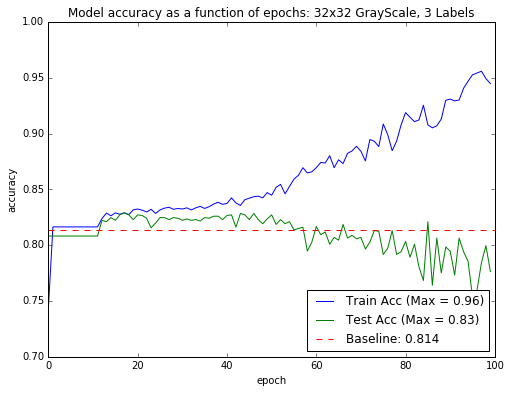

In [108]:
model = build_cnn(n_layers=4, 
                    filters=[32] * 4, 
                    kernels=[(2,2)] * 4, 
                    input_shape = input_shape_gray_32_32,
                    n_labels = 3,
                    a_func='relu')

model.summary()
compile_cnn(model)

model_history, model_score = train_cnn(model=model, 
                                           x_train=x_train_gray_32_32, 
                                           y_train=y_train_3,
                                           x_test=x_test_gray_32_32,
                                           y_test=y_test_3, 
                                           batch_size=batch_size,
                                           epochs=100)

model_info["model_3"] = {}
model_info["model_3"]["model_history"] = model_history
model_info["model_3"]["model_score"] = model_score

plot_acc(model_history, baseline=CONS_BASELNE_ACC_3, add_title="32x32 GrayScale, 3 Labels")

We're getting a 2% increase over the baseline!

### Model 3 Again (64x64 GrayScale, 3 Labels)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_53 (Conv2D)           (None, 63, 63, 32)        160       
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 30, 30, 32)        4128      
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 14, 14, 32)        4128      
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 6, 6, 32)          4128      
__________

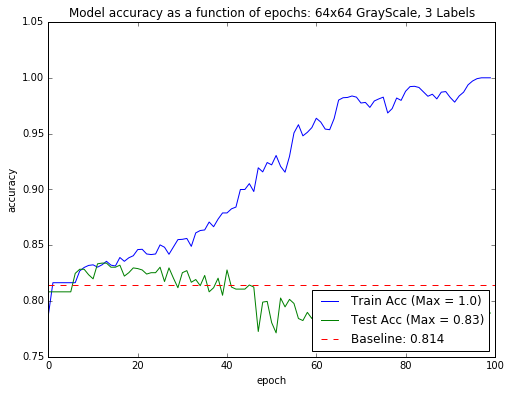

In [109]:
model = build_cnn(n_layers=4, 
                    filters=[32] * 4, 
                    kernels=[(2,2)] * 4, 
                    input_shape = input_shape_gray_64_64,
                    n_labels = 3,
                    a_func='relu')

model.summary()
compile_cnn(model)

model_history, model_score = train_cnn(model=model, 
                                           x_train=x_train_gray_64_64, 
                                           y_train=y_train_3,
                                           x_test=x_test_gray_64_64,
                                           y_test=y_test_3, 
                                           batch_size=batch_size,
                                           epochs=100)

model_info["model_3"] = {}
model_info["model_3"]["model_history"] = model_history
model_info["model_3"]["model_score"] = model_score

plot_acc(model_history, baseline=CONS_BASELNE_ACC_3, add_title="64x64 GrayScale, 3 Labels")

### Model 3 Again (32x32 RGB, 3 Labels)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_61 (Conv2D)           (None, 31, 31, 32)        416       
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 14, 14, 32)        4128      
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 6, 6, 32)          4128      
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 2, 2, 32)          4128      
__________

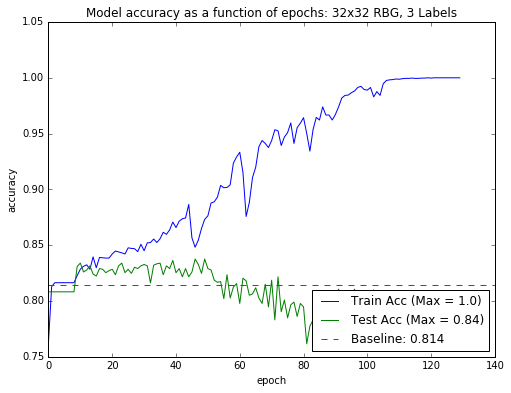

In [111]:
model = build_cnn(n_layers=4, 
                    filters=[32] * 4, 
                    kernels=[(2,2)] * 4, 
                    input_shape = input_shape_color_32_32,
                    n_labels = 3,
                    a_func='relu')

model.summary()
compile_cnn(model)

model_history, model_score = train_cnn(model=model, 
                                           x_train=x_train_rgb_32_32, 
                                           y_train=y_train_3,
                                           x_test=x_test_rgb_32_32,
                                           y_test=y_test_3, 
                                           batch_size=batch_size,
                                           epochs=130)

model_info["model_3"] = {}
model_info["model_3"]["model_history"] = model_history
model_info["model_3"]["model_score"] = model_score

plot_acc(model_history, baseline=CONS_BASELNE_ACC_3, add_title="32x32 RBG, 3 Labels")

3% increase!

### Model 3 Again (64x64 RGB, 3 Labels)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_65 (Conv2D)           (None, 63, 63, 32)        416       
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 30, 30, 32)        4128      
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 14, 14, 32)        4128      
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 6, 6, 32)          4128      
__________

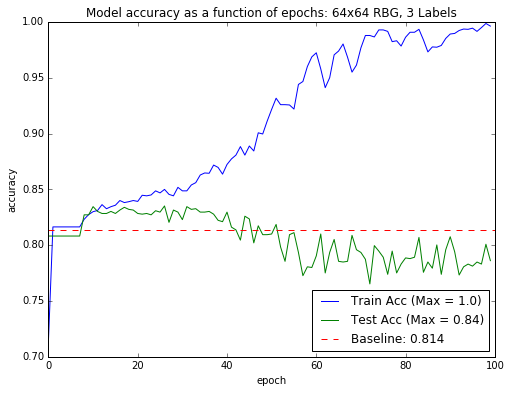

In [112]:
model = build_cnn(n_layers=4, 
                    filters=[32] * 4, 
                    kernels=[(2,2)] * 4, 
                    input_shape = input_shape_color_64_64,
                    n_labels = 3,
                    a_func='relu')

model.summary()
compile_cnn(model)

model_history, model_score = train_cnn(model=model, 
                                           x_train=x_train_rgb_64_64, 
                                           y_train=y_train_3,
                                           x_test=x_test_rgb_64_64,
                                           y_test=y_test_3, 
                                           batch_size=batch_size,
                                           epochs=100)

model_info["model_3"] = {}
model_info["model_3"]["model_history"] = model_history
model_info["model_3"]["model_score"] = model_score

plot_acc(model_history, baseline=CONS_BASELNE_ACC_3, add_title="64x64 RBG, 3 Labels")

Still a 3% increase, probably not worth it for the huge blowup in parameters!

In milestone 4, we tried out various other models, which we excluded here because they weren't as powerful. That said, we do describe the models we tried out in the insights section below.

In the above section, we took the two best models from milestone 4 (model 1 and model 3), and tried out all combinations of size (32x32 or 64x64) and color (grayscale and RBG). We found a solid increase in performance over baseline when we used 3 labels instead of 19, though the effect of color and size isn't as massive as we thought it would be.

Further analysis of these CNNs built from scratch can be found in the final paper submission.

# Discussion of the results, how much improvement you gained with fine tuning, etc. (from Milestone 4)

## Insights from tuning our built-from-scratch CNN

We built our from-scratch Convolutional Neural Network under the general premise that deeper networks (i.e. those with more layers) are better, given that we have the computational capacity and data size to support this increased model complexity.

We tried out many different models at first. For example:

#### Model 1: 
* 1 convolution layer & 1 pool layer
* 8 filters applied to convolution layer
* Convolution kernels of size 3x3
* relU activation function

#### Model 2
* 3 convolution layers & 3 pool layers
* 8 filters applied to each convolution layer
* Convolution kernels of size 3x3
* relU activation function

#### Model 3
* 4 convolution layers & 4 pool layers
* 32 filters applied to convolution layer
* Convolution kernels of size 2, 2
* relU activation function

#### Model 4
* Same as model 3, but with a lower learning rate (0.01) and higher momentum (0.99)

#### Model 5 (Harnessing bigger images!) - 256x256 images
* 5 convolution layers & 5 pool layers
* [8, 16, 32, 64, 128] filters applied to layers, respectively
* Convolution kernels of size 3, 3
* relU activation function

**Insights learned up to this point:** We manually tried various parameters in the first 5 parameters, from increasing the numebr of layers (both convolution and max pool layers), changing the number of filters we used to convolv each layer, changing the kernel size of these filters, lowering the learning rate, increasing momentum, and, lastly, as a hail mary, increasing image size to 256x256.

We were never able to increase the accuracy past the baseline, which is the number representing the accuracy of a trivial classifier which guesses all 0.

This is likely because the label matrix is incredibly sparse and is roughly 82% 0, meaning that our multi-label problem is a needle-in-the-haystack problem.

To fix this, we'd likely need way more training data so that we can actually find patterns in the labels. After all, we had about 17 labels total in the first 5 models. 

Instead of increasing training data, we tried to make our task slightly more teneble --> we collapsed all 17 genres into 3 more general genres: "heartbeat", which represents movies which usually make your heart race, "lighthearted", which represents movies which are generally lighthearted and fun or romantic, and "other", which are movies that are usually not lighthearted or innately exciting. 

After collapsing our labels into three columns, we tried various models again:

* Model 3
* Model 1
* Model 4

What we found is that Models 1 and 4 got 84% accuracy, while the baseline accuracy was about 80%, meaning that we successfully were able to supercede the baseline! This is even more impressive when you consider that the new label data (that is, the label data with the three new genre categories) is about 50% 0s and 1s, so an ultra-trivial classifier would get just about 50% of the labels correctly. That said, the average of a trivial classifier's accuracy for each column separately gives about 80% accuracy in total, and we chose to use this more strict baseline because it seems more likely that this is what a trivial neural net would do.

In the end, our best, most parsimonious model was model 1 and had parameters:

* 1 convolution layer & 1 pool layer
* 8 filters applied to convolution layer
* Convolution kernels of size 3x3
* relU activation function for the convolution layers
* .1 learning rate and .9 momentum for the SGD optimization

One thing that suprised us is that we only needed 1 convolution layer and 1 max pool layer to get peak accuracy, and using more layers didn't seem to improve accuracy much more. Our work over the next week will try to explore why this is, and whether there are other parameters that we might want to try tuning as well!